In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
#image loading
img = cv2.imread('../IMAGES/test_img.png', 0)

In [14]:
# 1. Write a program to perform the Huffman coding techniques on an image and compute Compression Ratio.

def huffman_coding(symbols, probabilities):

  # Create a symbol-frequency table
  symbol_freq = dict(zip(symbols, probabilities))

  # Create a Huffman tree using a priority queue (based on frequency)
  class Node:
    def __init__(self, symbol, freq, left=None, right=None):
      self.symbol = symbol
      self.freq = freq
      self.left = left
      self.right = right

    def __lt__(self, other):
      return self.freq > other.freq  # Invert for min-heap

  heap = [Node(symbol, freq) for symbol, freq in symbol_freq.items()]
  import heapq
  while len(heap) > 1:
    left = heapq.heappop(heap)
    right = heapq.heappop(heap)
    parent = Node(None, left.freq + right.freq, left, right)
    heapq.heappush(heap, parent)

  # Traverse the Huffman tree to generate codes
  codes = {}
  def traverse(node, code):
    if node is None:
      return
    if node.symbol is not None:
      codes[node.symbol] = code
      return
    traverse(node.left, code + '0')
    traverse(node.right, code + '1')
  traverse(heap[0], '')

  return codes

def compress_image(image):
  
  # Get the histogram (symbol frequencies)
  intensity_counts = Counter(image.flatten())
  intensities = list(intensity_counts.keys())
  probabilities = [count / len(image.flatten()) for count in intensity_counts.values()]

  # Create Huffman codes
  codes = huffman_coding(intensities, probabilities)

  # Encode the image using Huffman codes (replace with actual encoding logic)
  compressed_data = ''.join([codes[intensity] for intensity in image.flatten()])

  return compressed_data, codes

def calculate_compression_ratio(original_size, compressed_size):
  

  return 1 - compressed_size / original_size


# Convert image to NumPy array for processing
image_array = image.copy() 

# Perform compression steps
compressed_data, codes = compress_image(image_array)

# Calculate sizes for compression ratio (assuming uint8 data type)
original_size = image.size * image.dtype.itemsize
compressed_size = len(compressed_data) * len(codes.keys())

compression_ratio = calculate_compression_ratio(original_size, compressed_size)

print(f"Compression Ratio: {compression_ratio:.4f}")


Compression Ratio: -58091.6591


In [8]:
# 2. Take an image, apply Fourier transformation, quantize data and apply Huffman coding. Apply Huffman decoding and inverse Fourier to obtain reconstructed image. Calculate  CR and PSNR


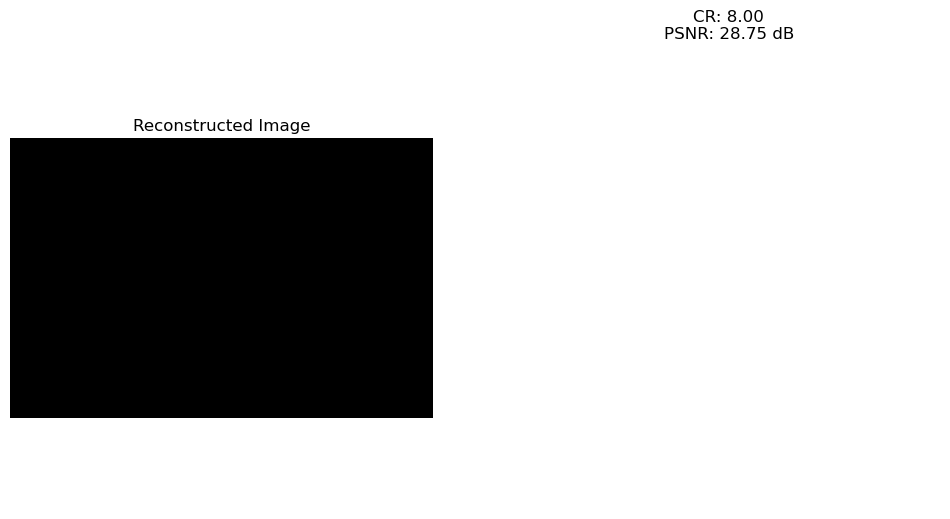

In [18]:
import numpy as np
from scipy.fft import fft2, ifft2
from PIL import Image
from sklearn.preprocessing import QuantileTransformer
import heapq
import collections
import matplotlib.pyplot as plt

# Helper functions for Huffman Coding
def build_huffman_tree(data):
    frequency = collections.Counter(data)
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    
    huffman_tree = sorted(heapq.heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
    return dict((symbol, code) for symbol, code in huffman_tree)

def huffman_encoding(data, huffman_tree):
    return ''.join(huffman_tree[symbol] for symbol in data)

def huffman_decoding(encoded_data, huffman_tree):
    reverse_tree = {code: symbol for symbol, code in huffman_tree.items()}
    decoded_data = []
    code = ''
    for bit in encoded_data:
        code += bit
        if code in reverse_tree:
            decoded_data.append(reverse_tree[code])
            code = ''
    return decoded_data

# Read and process image
def process_image(image_path):
    # Load image
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)

    # Apply Fourier Transform
    f_transform = fft2(img_array)
    magnitude = np.abs(f_transform)
    
    # Quantize data
    quantizer = QuantileTransformer(output_distribution='uniform')
    quantized_data = quantizer.fit_transform(magnitude.reshape(-1, 1)).reshape(magnitude.shape)
    
    # Flatten quantized data for Huffman coding
    flat_quantized_data = quantized_data.flatten()
    
    # Create Huffman tree and encode
    huffman_tree = build_huffman_tree(flat_quantized_data.astype(int))
    encoded_data = huffman_encoding(flat_quantized_data.astype(int), huffman_tree)
    
    # Decode Huffman encoded data
    decoded_data = huffman_decoding(encoded_data, huffman_tree)
    
    # Convert decoded data back to quantized data
    decoded_quantized_data = np.array(decoded_data).reshape(magnitude.shape)
    
    # Inverse Fourier Transform
    f_transform_reconstructed = ifft2(decoded_quantized_data)
    reconstructed_image = np.abs(f_transform_reconstructed)
    
    # Convert reconstructed image to uint8 format
    reconstructed_image_uint8 = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

    # Calculate Compression Ratio (CR)
    original_size = img_array.size * img_array.itemsize
    encoded_size = len(encoded_data) / 8  # in bytes
    CR = original_size / encoded_size

    # Calculate PSNR
    mse = np.mean((img_array - reconstructed_image_uint8) ** 2)
    if mse == 0:
        psnr = 100
    else:
        max_pixel = 255.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    
    return reconstructed_image_uint8, CR, psnr

# Process the image and obtain results
reconstructed_image, CR, PSNR = process_image('../IMAGES/test_img.png')

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'CR: {CR:.2f}\nPSNR: {PSNR:.2f} dB')
plt.axis('off')
plt.show()
